In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model


In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 256

CHANNELS=3  
EPOCHS=35


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2147 files belonging to 3 classes.


potato_early_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato_Early_blight"

potato_lately_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___Late_blight"

potato_healthy = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___healthy"

In [5]:
class_names = dataset.class_names

class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #batch size 32 256 image size 

(16, 256, 256, 3)
[1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0]


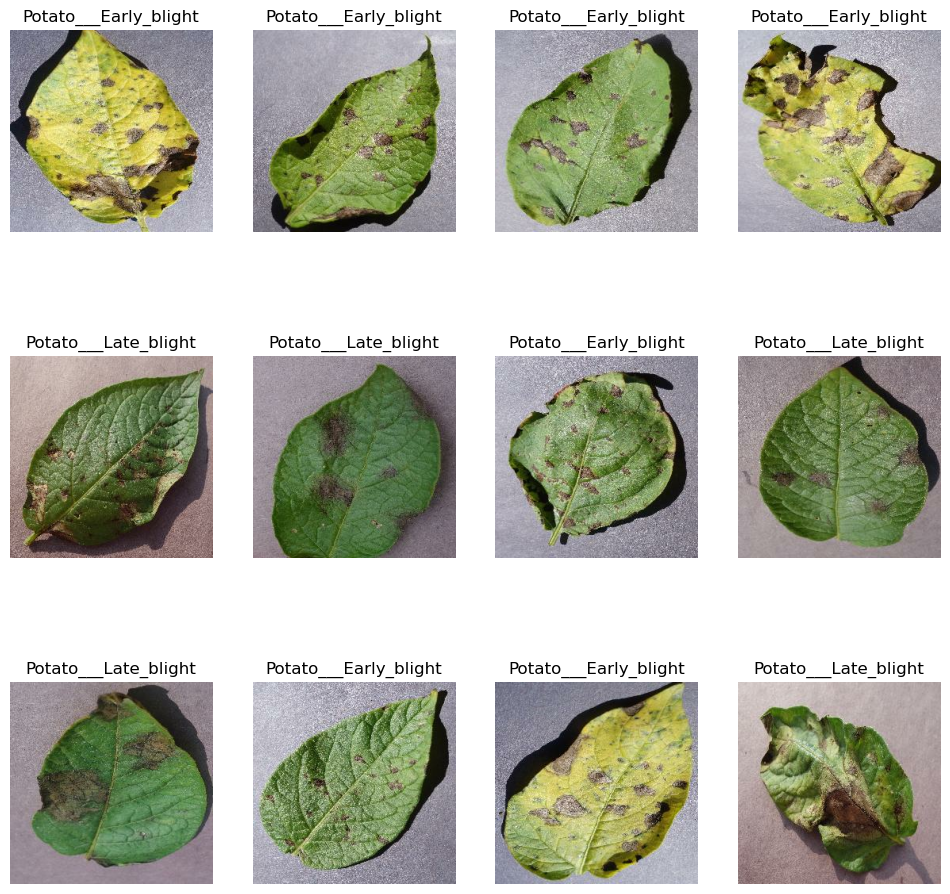

In [7]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #random
        plt.title(class_names[labels_batch[i]]) 
        plt.axis("off")

# SPLITTING

80% ==>training 20% ==>10% for testing other 10% for validating

In [8]:
len(dataset)    #total images/batch size


135

In [9]:
train_size = 0.8                #580*.8  for training


In [10]:
len(dataset)*train_size


108.0

In [11]:
train_ds = dataset.take(108)     


In [12]:
len(train_ds)

108

In [13]:
test_ds = dataset.skip(108)


In [14]:
len(test_ds)

27

In [15]:
val_size=0.1


In [16]:
len(dataset)*val_size

13.5

In [17]:
val_ds = test_ds.take(13)


In [18]:
len(val_ds)

13

In [19]:
test_ds = test_ds.skip(13)


In [20]:
len(test_ds)

14

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

108

In [24]:
len(val_ds)

13

In [25]:
len(test_ds)

14

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Getting images into same size

In [27]:
resize_and_rescale = tf.keras.Sequential([
    
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
    
])


Changing the image style


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


BUILDING THE MODEL


In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3


In [31]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=35,
)

Epoch 1/35
108/108 [==============================] - 156s 1s/step - loss: 0.8351 - accuracy: 0.5214 - val_loss: 0.6227 - val_accuracy: 0.7436
Epoch 2/35
108/108 [==============================] - 139s 1s/step - loss: 0.5529 - accuracy: 0.7350 - val_loss: 0.4726 - val_accuracy: 0.7487
Epoch 3/35
108/108 [==============================] - 142s 1s/step - loss: 0.3959 - accuracy: 0.8264 - val_loss: 0.3560 - val_accuracy: 0.8308
Epoch 4/35
108/108 [==============================] - 140s 1s/step - loss: 0.3219 - accuracy: 0.8704 - val_loss: 0.2090 - val_accuracy: 0.9333
Epoch 5/35
108/108 [==============================] - 143s 1s/step - loss: 0.2382 - accuracy: 0.9097 - val_loss: 0.1486 - val_accuracy: 0.9282
Epoch 6/35
108/108 [==============================] - 143s 1s/step - loss: 0.2029 - accuracy: 0.9184 - val_loss: 0.2019 - val_accuracy: 0.9231
Epoch 7/35
108/108 [==============================] - 135s 1s/step - loss: 0.1967 - accuracy: 0.9236 - val_loss: 0.1728 - val_accuracy: 0.9026

In [36]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 6s 290ms/step - loss: 0.0704 - accuracy: 0.9777


In [37]:
scores

[0.07040048390626907, 0.9776785969734192]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 108}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

35

In [43]:
history.history['loss'][:5] 

[0.8351413607597351,
 0.552897572517395,
 0.39592328667640686,
 0.321851521730423,
 0.23823882639408112]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(val_acc)

[0.7435897588729858, 0.7487179636955261, 0.8307692408561707, 0.9333333373069763, 0.928205132484436, 0.9230769276618958, 0.9025641083717346, 0.9435897469520569, 0.9333333373069763, 0.8820512890815735, 0.964102566242218, 0.964102566242218, 0.9487179517745972, 0.8974359035491943, 0.9692307710647583, 0.9897435903549194, 0.9794871807098389, 0.9179487228393555, 0.9743589758872986, 0.9384615421295166, 0.9384615421295166, 0.9743589758872986, 0.9794871807098389, 0.9487179517745972, 0.9846153855323792, 0.9794871807098389, 0.9692307710647583, 0.9333333373069763, 0.9846153855323792, 0.9897435903549194, 0.9897435903549194, 0.9897435903549194, 0.9794871807098389, 0.964102566242218, 0.9948717951774597]


In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(val_loss)

[0.6226747632026672, 0.4725698232650757, 0.3559786379337311, 0.2090274840593338, 0.14858245849609375, 0.20187802612781525, 0.17279544472694397, 0.13339468836784363, 0.1451808661222458, 0.2664051651954651, 0.08437590301036835, 0.07577241957187653, 0.16273033618927002, 0.19388031959533691, 0.08805297315120697, 0.0635201558470726, 0.06534100323915482, 0.2200484424829483, 0.05889204889535904, 0.1562407910823822, 0.12705326080322266, 0.08476866781711578, 0.07012563198804855, 0.097577765583992, 0.041526228189468384, 0.07163844257593155, 0.05454092100262642, 0.15142305195331573, 0.05554746091365814, 0.0333857499063015, 0.03381001949310303, 0.03844667226076126, 0.03932946175336838, 0.06168869137763977, 0.03241454064846039]


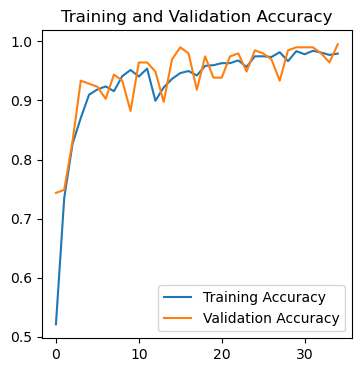

In [46]:
plt.figure(figsize=(4, 4))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.show()

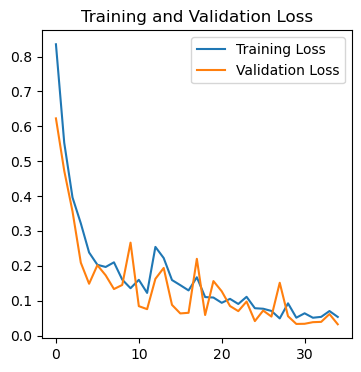

In [47]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

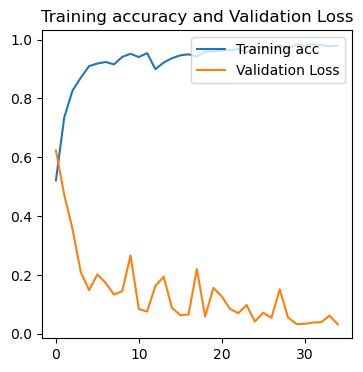

In [48]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), acc, label='Training acc')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy and Validation Loss')

plt.show()

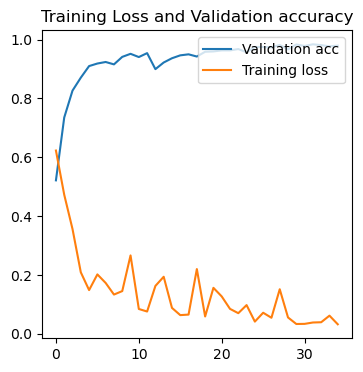

In [49]:
plt.figure(figsize=(4,4 ))
plt.plot(range(EPOCHS), acc, label='Validation acc')
plt.plot(range(EPOCHS), val_loss, label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation accuracy')

plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 407ms/step
predicted label: Potato___Late_blight


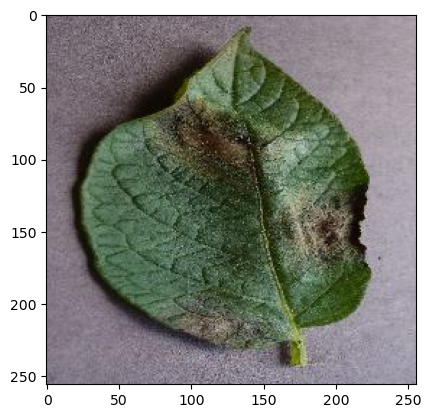

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


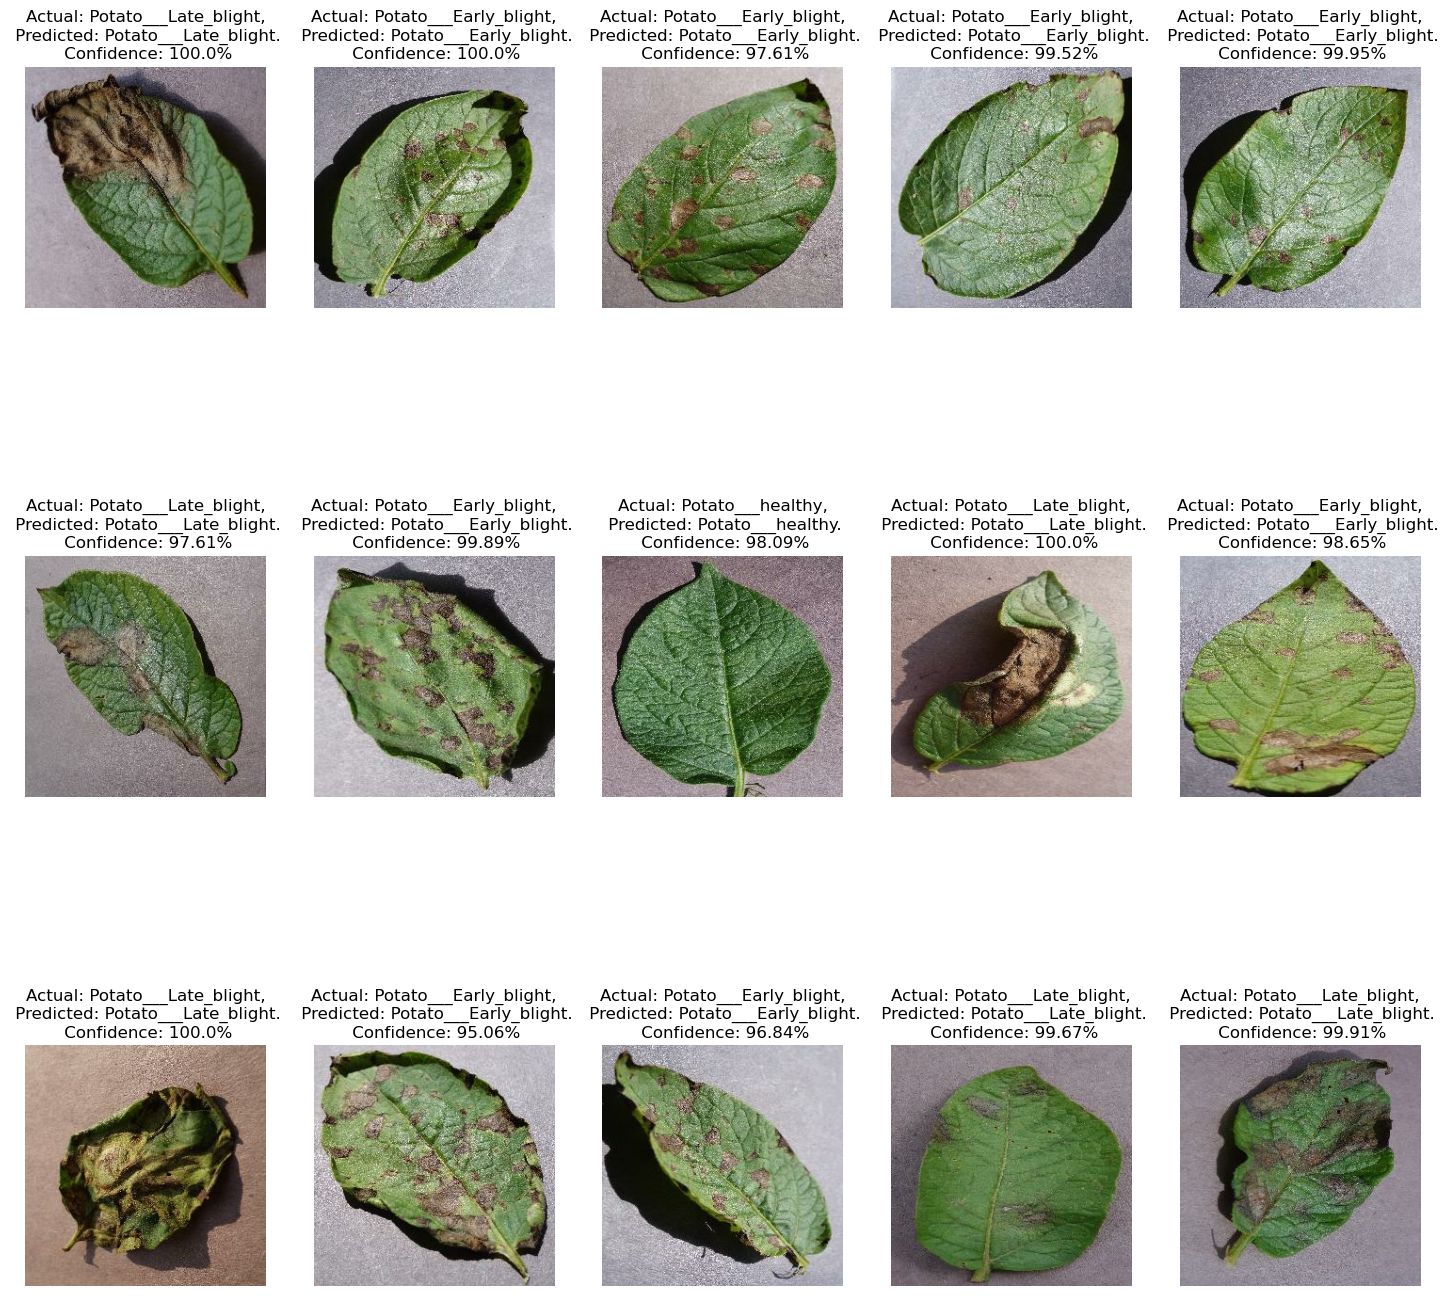

In [52]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
import os
os.listdir("../potatomodel")

['3']

In [54]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../potatomodel/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [ ]:
model.save("../potato.h5")